In [1]:
import pandas as pd
import numpy as np

# =====================================================
# 1️⃣ 데이터 로드
# =====================================================
csv_path = "new_flight_weather_merged.csv"
df = pd.read_csv(csv_path)

print("✅ CSV 로드 완료")
print("전체 행 수:", len(df))

C:\Users\Admin\AppData\Local\Temp\ipykernel_4880\178406495.py:8: DtypeWarning: Columns (31,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


✅ CSV 로드 완료
전체 행 수: 2836872


In [2]:
# =====================================================
# 2️⃣ 상태 == '지연' 데이터만 사용
# -----------------------------------------------------
# ✔ 지연시간 회귀는 '지연이 발생한 항공편'만 의미가 있음
# ✔ 정상/결항/회항 데이터는 회귀 대상이 아님
# =====================================================
reg_df = df[df["상태"] == "지연"].copy()
print("⏱ 상태=지연 데이터 수:", len(reg_df))

⏱ 상태=지연 데이터 수: 480982


In [3]:
# =====================================================
# 3️⃣ 지연_분 분포 확인 (정제 전)
# -----------------------------------------------------
# ✔ 데이터 이상치/결측치 여부 파악 목적
# =====================================================
print("📊 정제 전 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 정제 전 지연_분 분포
count    480982.000000
mean         57.602601
std          42.985101
min       -1414.000000
25%          36.000000
50%          46.000000
75%          64.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [4]:
# =====================================================
# 4️⃣ 지연_분 정제
# -----------------------------------------------------
# ✔ y(target)에 NaN이 있으면 모델 학습 불가
# ✔ 음수 지연은 논리적으로 불가능
# =====================================================

# ❗ 지연_분 NaN 제거 (가장 중요)
reg_df = reg_df[reg_df["지연_분"].notna()]

# ❗ 음수 제거
reg_df = reg_df[reg_df["지연_분"] >= 0].copy()

print("📊 음수 + NaN 제거 후 지연_분 분포")
print(reg_df["지연_분"].describe())

📊 음수 + NaN 제거 후 지연_분 분포
count    480517.000000
mean         57.753488
std          41.523529
min           0.000000
25%          36.000000
50%          46.000000
75%          65.000000
max        1391.000000
Name: 지연_분, dtype: float64


In [5]:
# =====================================================
# 5️⃣ 지연시간 상한 컷
# -----------------------------------------------------
# ✔ 360분(6시간) 이상은 이벤트성 지연
# ✔ 회귀 모델 안정화를 위해 상한 적용
# =====================================================
MAX_DELAY = 360
reg_df = reg_df[reg_df["지연_분"] <= MAX_DELAY].copy()

print("📊 상한 컷 후 지연_분 분포")
print(reg_df["지연_분"].describe())


📊 상한 컷 후 지연_분 분포
count    479429.000000
mean         56.744999
std          34.943600
min           0.000000
25%          36.000000
50%          46.000000
75%          64.000000
max         360.000000
Name: 지연_분, dtype: float64


In [6]:
# =====================================================
# 6️⃣ Feature 정의
# -----------------------------------------------------
# ✔ 분류 모델과 동일한 입력 사용
# ✔ 기상 + 시간 + 공항 정보
# =====================================================

# 🔢 수치형 변수
num_cols = [
    "기온(°C)",
    "풍속_ms",
    "dep_hour",
    "dep_minute",
    "dep_weekday",
    "is_weekend"
]

cat_cols = [
    "항공사",
    "출발지",
    "arrival_code",
    "flight_type"
]


# 실제 존재하는 컬럼만 사용
num_cols = [c for c in num_cols if c in reg_df.columns]
cat_cols = [c for c in cat_cols if c in reg_df.columns]

X_cols = num_cols + cat_cols

In [7]:
# =====================================================
# 7️⃣ 시간 기준 Train / Test 분리
# -----------------------------------------------------
# ✔ 미래 정보 누수 방지
# ✔ 실제 운영 상황과 동일한 분리 방식
# =====================================================
reg_df["departure_datetime"] = pd.to_datetime(reg_df["departure_datetime"])
reg_df["dep_minute"] = reg_df["departure_datetime"].dt.minute
reg_df = reg_df.sort_values("departure_datetime")

split_date = reg_df["departure_datetime"].quantile(0.8)

train_df = reg_df[reg_df["departure_datetime"] <= split_date]
test_df  = reg_df[reg_df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["지연_분"]

X_test  = test_df[X_cols]
y_test  = test_df["지연_분"]

print("Train:", len(X_train), "Test:", len(X_test))

Train: 383544 Test: 95885


In [8]:
# =====================================================
# 8️⃣ y(target) NaN 사전 점검 및 제거
# -----------------------------------------------------
# ✔ y에 NaN이 있으면 모델 학습 불가
# ✔ X와 y를 동시에 정제하여 인덱스 불일치 방지
# =====================================================
print("y_train NaN 수:", y_train.isna().sum())
print("y_test  NaN 수:", y_test.isna().sum())

train_mask = y_train.notna()
test_mask  = y_test.notna()

X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]

X_test  = X_test.loc[test_mask]
y_test  = y_test.loc[test_mask]

print("NaN 제거 후 Train:", len(X_train), "Test:", len(X_test))

y_train NaN 수: 0
y_test  NaN 수: 0
NaN 제거 후 Train: 383544 Test: 95885


In [9]:
# =====================================================
# 9️⃣ 전처리 파이프라인
# -----------------------------------------------------
# ✔ 수치형: 중앙값 대치
# ✔ 범주형: UNKNOWN + One-Hot Encoding
# =====================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [10]:
# =====================================================
# 🔟 Linear Regression (Baseline)
# -----------------------------------------------------
# ✔ 가장 단순한 기준 모델
# =====================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lin_reg = Pipeline([
    ("prep", preprocessor),
    ("reg", LinearRegression())
])

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

print("📊 Linear Regression")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


📊 Linear Regression
MAE : 22.152635637822684
RMSE: 31.00054536412771


In [11]:
# =====================================================
# 1️⃣1️⃣ Ridge Regression
# -----------------------------------------------------
# ✔ 다중공선성 완화
# ✔ 선형 모델 중 가장 안정적
# =====================================================
from sklearn.linear_model import Ridge

ridge_reg = Pipeline([
    ("prep", preprocessor),
    ("reg", Ridge(alpha=1.0))
])

ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)

print("📊 Ridge Regression")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

📊 Ridge Regression
MAE : 22.150367783423626
RMSE: 30.99561527336959


In [12]:
# =====================================================
# 1️⃣2️⃣ Log-Ridge Regression
# -----------------------------------------------------
# ✔ 지연시간의 long-tail 분포 대응
# ✔ 실제 성능 개선 효과 큼
# =====================================================
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

ridge_reg.fit(X_train, y_train_log)

y_pred_log = ridge_reg.predict(X_test)
y_pred = np.expm1(y_pred_log)

print("📊 Log-Ridge Regression")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

📊 Log-Ridge Regression
MAE : 19.267720396258202
RMSE: 30.065088674507788


In [13]:
# =====================================================
# 1️⃣3️⃣ 예측 결과 확인
# =====================================================
result_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "predicted_delay": y_pred
})

result_df.head(20)

,actual_delay,predicted_delay
0,71.0,64.116328
1,79.0,44.051100
2,95.0,66.154754
3,47.0,47.095340
4,154.0,72.582090
5,216.0,62.331409
6,91.0,62.121275
7,63.0,64.675149
8,29.0,47.192929
9,85.0,66.651736


In [14]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [15]:
lgbm_reg = Pipeline([
    ("prep", preprocessor),
    ("reg", LGBMRegressor(
        objective="regression",
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

lgbm_reg.fit(X_train, y_train)

y_pred_lgbm = lgbm_reg.predict(X_test)

print("🌳 LightGBM Regression (raw)")
print("MAE :", mean_absolute_error(y_test, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 383544, number of used features: 316
[LightGBM] [Info] Start training from score 57.365679
🌳 LightGBM Regression (raw)
MAE : 20.102261053009375
RMSE: 28.406545879491773


In [16]:
# 타겟 로그 변환
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

lgbm_reg.fit(X_train, y_train_log)

y_pred_log = lgbm_reg.predict(X_test)
y_pred_lgbm_log = np.expm1(y_pred_log)

print("🌳 LightGBM Regression (log target)")
print("MAE :", mean_absolute_error(y_test, y_pred_lgbm_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm_log)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 383544, number of used features: 316
[LightGBM] [Info] Start training from score 3.945627
🌳 LightGBM Regression (log target)
MAE : 17.757752883496792
RMSE: 28.059010334166356


In [17]:
compare_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "pred_log_ridge": y_pred,              # 기존 Log-Ridge 결과
    "pred_lgbm_log": y_pred_lgbm_log        # LightGBM Log 결과
})

compare_df.head(20)


,actual_delay,pred_log_ridge,pred_lgbm_log
0,71.0,64.116328,66.592307
1,79.0,44.051100,44.323734
2,95.0,66.154754,71.035526
3,47.0,47.095340,48.323674
4,154.0,72.582090,78.808979
5,216.0,62.331409,67.478803
6,91.0,62.121275,68.740228
7,63.0,64.675149,64.722721
8,29.0,47.192929,47.418971
9,85.0,66.651736,65.929903


MAE (Mean Absolute Error) 

평균적으로 예측이 실제 값과 차이

RMSE (Root Mean Squared Error)

큰 오차(장시간 지연)에 더 민감한 평균 오차

✔️ MAE 기준

“이 모델은 평균적으로 약 XX분 오차로 지연시간을 예측한다”

✔️ RMSE 기준

“큰 지연에서도 예측이 얼마나 안정적인지”


In [18]:
# =====================================================
# 📊 1️⃣ 모델 성능 비교 표 (MAE / RMSE)
# =====================================================
# 목적
# - 여러 회귀 모델의 성능을 한 눈에 비교
# - PPT에서 "그래서 어떤 모델이 제일 좋은가?"를 보여주는 핵심 표
#
# 지표 설명
# - MAE : 평균적으로 몇 분 정도 틀리는지
# - RMSE: 큰 지연(장시간 지연)에 얼마나 민감한지
# =====================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

summary_df = pd.DataFrame({
    "모델": [
        "Linear Regression",
        "Ridge Regression",
        "Log-Ridge Regression",
        "LightGBM (Raw Target)",
        "LightGBM (Log Target)"
    ],
    "MAE (분)": [
        mean_absolute_error(y_test, lin_reg.predict(X_test)),
        mean_absolute_error(y_test, ridge_reg.predict(X_test)),
        mean_absolute_error(y_test, y_pred),               # Log-Ridge 결과
        mean_absolute_error(y_test, y_pred_lgbm),
        mean_absolute_error(y_test, y_pred_lgbm_log)
    ],
    "RMSE (분)": [
        np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test))),
        np.sqrt(mean_squared_error(y_test, ridge_reg.predict(X_test))),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        np.sqrt(mean_squared_error(y_test, y_pred_lgbm)),
        np.sqrt(mean_squared_error(y_test, y_pred_lgbm_log))
    ]
})

summary_df


,모델,MAE (분),RMSE (분)
0,Linear Regression,22.152636,31.000545
1,Ridge Regression,50.259198,59.093265
2,Log-Ridge Regression,19.267720,30.065089
3,LightGBM (Raw Target),20.102261,28.406546
4,LightGBM (Log Target),17.757753,28.059010


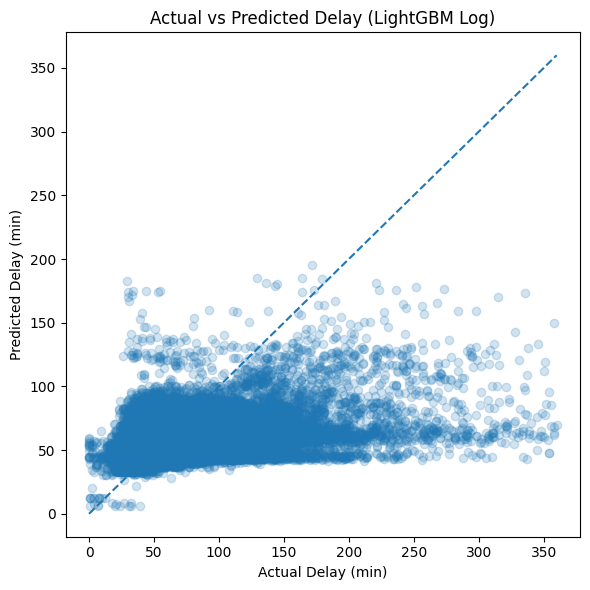

In [19]:
# =====================================================
# 📈 2️⃣ 실제 지연시간 vs 예측 지연시간 (산점도)
# =====================================================
# 목적
# - 예측값이 실제 지연시간을 얼마나 잘 따라가는지 시각적으로 확인
# - 점들이 대각선(y=x)에 가까울수록 좋은 모델
# =====================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# 실제값(x) vs 예측값(y)
plt.scatter(
    y_test,
    y_pred_lgbm_log,
    alpha=0.2   # 데이터가 많으므로 투명도 적용
)

# 완벽한 예측 기준선 (y = x)
max_val = max(y_test.max(), y_pred_lgbm_log.max())
plt.plot(
    [0, max_val],
    [0, max_val],
    linestyle="--"
)

plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Actual vs Predicted Delay (LightGBM Log)")

plt.tight_layout()
plt.show()


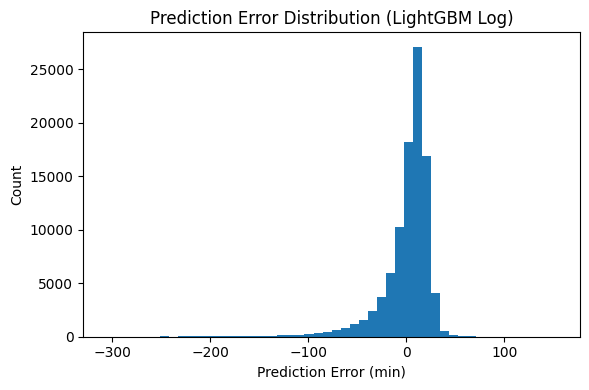

In [20]:
# =====================================================
# 📉 3️⃣ 예측 오차 분포 히스토그램
# =====================================================
# 목적
# - 모델이 보통 어느 정도 틀리는지 확인
# - 오차가 0 근처에 몰릴수록 안정적인 모델
# =====================================================

# 예측 오차 계산
errors = y_pred_lgbm_log - y_test

plt.figure(figsize=(6, 4))

plt.hist(
    errors,
    bins=50     # 오차 분포를 자세히 보기 위해 bin 수 증가
)

plt.xlabel("Prediction Error (min)")
plt.ylabel("Count")
plt.title("Prediction Error Distribution (LightGBM Log)")

plt.tight_layout()
plt.show()


In [21]:
# =====================================================
# 📊 4️⃣ 지연시간 구간별 MAE 계산
# =====================================================
# 목적
# - 짧은 지연 / 긴 지연 구간에서 성능 차이 확인
# - 실무 보고에서 설득력이 매우 높은 분석
# =====================================================

# 지연시간 구간 정의
bins = [0, 30, 60, 120, 240, 360]
labels = ["0–30", "30–60", "60–120", "120–240", "240–360"]

bucket_df = pd.DataFrame({
    "actual_delay": y_test.values,
    "pred_delay": y_pred_lgbm_log
})

# 실제 지연시간 기준으로 구간화
bucket_df["delay_bucket"] = pd.cut(
    bucket_df["actual_delay"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# 구간별 MAE 계산
bucket_mae = bucket_df.groupby("delay_bucket").apply(
    lambda x: mean_absolute_error(x["actual_delay"], x["pred_delay"])
).reset_index(name="MAE")

bucket_mae


,delay_bucket,MAE
0,0–30,18.488129
1,30–60,11.608296
2,60–120,22.098298
3,120–240,86.093197
4,240–360,201.516093


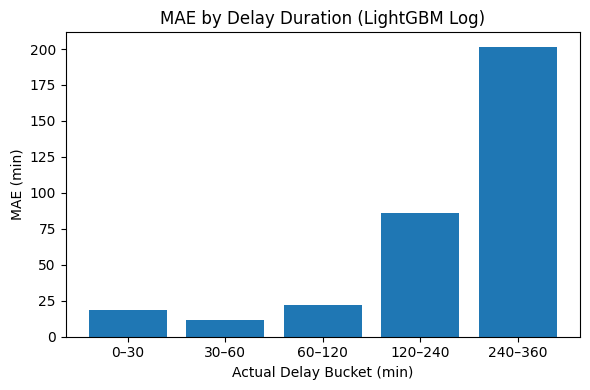

In [22]:
# =====================================================
# 📊 5️⃣ 지연시간 구간별 MAE 시각화
# =====================================================
# 목적
# - 지연 시간이 길어질수록 예측이 얼마나 어려워지는지 시각화
# =====================================================

plt.figure(figsize=(6, 4))

plt.bar(
    bucket_mae["delay_bucket"],
    bucket_mae["MAE"]
)

plt.xlabel("Actual Delay Bucket (min)")
plt.ylabel("MAE (min)")
plt.title("MAE by Delay Duration (LightGBM Log)")

plt.tight_layout()
plt.show()


In [23]:
# =====================================================
# 📋 6️⃣ 예측 결과 샘플 테이블 (Appendix용)
# =====================================================
# 목적
# - 실제 예측 사례를 PPT 부록에서 보여주기 위함
# =====================================================

result_df = pd.DataFrame({
    "Actual Delay (min)": y_test.values,
    "Predicted Delay (min)": y_pred_lgbm_log,
    "Error (min)": y_pred_lgbm_log - y_test.values
})

result_df.head(10)


,Actual Delay (min),Predicted Delay (min),Error (min)
0,71.0,66.592307,-4.407693
1,79.0,44.323734,-34.676266
2,95.0,71.035526,-23.964474
3,47.0,48.323674,1.323674
4,154.0,78.808979,-75.191021
5,216.0,67.478803,-148.521197
6,91.0,68.740228,-22.259772
7,63.0,64.722721,1.722721
8,29.0,47.418971,18.418971
9,85.0,65.929903,-19.070097


In [24]:
# =====================================================
# 💾 7️⃣ 최종 모델 저장 (운영 / 배포용)
# =====================================================

import joblib

final_model = lgbm_reg   # ✅ 이 줄이 핵심

joblib.dump(final_model, "모델_회기분석.joblib")

print("✅ 최종 모델 저장 완료: 모델_회기분석.joblib")


✅ 최종 모델 저장 완료: final_delay_model.joblib
